<a href="https://colab.research.google.com/github/Mahedi-Shuvro/seismic-velocity-inversion/blob/main/U-NETsolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install anytree

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Section 1: Imports and Configuration

In [6]:
import os                                                             # for file and path handling
import numpy as np                                                    # Numerical computations.
import matplotlib.pyplot as plt                                       # Data visualization
from glob import glob                                                 # Progress bars for loops.
from tqdm import tqdm
#Deep learning framework and essential modules (layers, functions, optimizers).
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split                  # Splitting dataset into training and testing subsets.
from utils import create_submission, calculate_mape, calculate_score  # Custom Utilities (Project-Specific-given)
from IPython.display import FileLink                                  # To allow file download links (for submissions or outputs).

# Data Analysis & Inspection

In [7]:
import zipfile
import os

def extract_zip(zip_path, extract_path):
    """Extracts a zip file to a given directory if not already extracted."""
    os.makedirs(extract_path, exist_ok=True)

    # Check if the directory is already populated
    if os.listdir(extract_path):
        print(f"✅ Data already extracted at: {extract_path}")
        return

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"✅ Extraction complete. Files extracted to: {extract_path}")
    except zipfile.BadZipFile:
        print(f"❌ Error: The zip file at {zip_path} is corrupted.")
    except FileNotFoundError:
        print(f"❌ Error: Zip file not found at {zip_path}.")

# File paths
train_zip = "/content/drive/MyDrive/Speed_and_Structure/speed-and-structure-train-data.zip"
train_extract = "/content/sample_data/speed-and-structure-train"

test_zip = "/content/drive/MyDrive/Speed_and_Structure/speed-and-structure-test-data.zip"
test_extract = "/content/sample_data/speed-and-structure-test"

# Extract datasets if not already extracted
extract_zip(train_zip, train_extract)
extract_zip(test_zip, test_extract)

# Optional: Show sample files to confirm
print("📂 Sample training files:", os.listdir(train_extract)[:5])
print("📂 Sample testing files:", os.listdir(test_extract)[:5])

✅ Extraction complete. Files extracted to: /content/sample_data/speed-and-structure-train
✅ Extraction complete. Files extracted to: /content/sample_data/speed-and-structure-test
📂 Sample training files: ['RSB3JMX0fsxskMJqal', '526va47UiLiO1ayBKi', 'ZKgUMdmJVDX7aw1EmM', '3DsmXa46leEKr77ml5', 'yfA7fd4YKXNWvlGhu3']
📂 Sample testing files: ['nfDm8HTlNvsRSP6Yrb', '20TqVh64gfLMvyxxlB', 'gkdeAGsNE9mVNRLlB6', 'm08dCENquMzX1ZMZUU', 'k4fRQjpKjaOh44ckBM']


In [8]:
# Path to training samples
train_dir = "/content/sample_data/speed-and-structure-train"
sample_folders = sorted([f for f in glob(os.path.join(train_dir, "*")) if os.path.isdir(f)])
print(f"📦 Total training samples: {len(sample_folders)}")

# Pick one to inspect
sample_path = sample_folders[0]
sample_id = os.path.basename(sample_path)
print(f"\n🔍 Inspecting sample: {sample_id}")

# Load all 5 receiver data inputs
receiver_indices = [1, 75, 150, 225, 300]
for i in receiver_indices:
    file_path = os.path.join(sample_path, f"receiver_data_src_{i}.npy")
    try:
        data = np.load(file_path)
        print(f"Loaded: receiver_data_src_{i}.npy - shape: {data.shape}, dtype: {data.dtype}")
    except FileNotFoundError:
        print(f"Missing file: receiver_data_src_{i}.npy")

# Load the velocity model
vp_path = os.path.join(sample_path, "vp_model.npy")
try:
    vp_model = np.load(vp_path)
    print(f"\n✅ Loaded: vp_model.npy - shape: {vp_model.shape}, dtype: {vp_model.dtype}")
except FileNotFoundError:
    print("Missing file: vp_model.npy")

📦 Total training samples: 2000

🔍 Inspecting sample: 00ady8InZofxhWZsDT
✅ Loaded: receiver_data_src_1.npy - shape: (10001, 31), dtype: float32
✅ Loaded: receiver_data_src_75.npy - shape: (10001, 31), dtype: float32
✅ Loaded: receiver_data_src_150.npy - shape: (10001, 31), dtype: float32
✅ Loaded: receiver_data_src_225.npy - shape: (10001, 31), dtype: float32
✅ Loaded: receiver_data_src_300.npy - shape: (10001, 31), dtype: float32

✅ Loaded: vp_model.npy - shape: (300, 1259), dtype: float64


🔍 Visualizing sample at: 00ady8InZofxhWZsDT


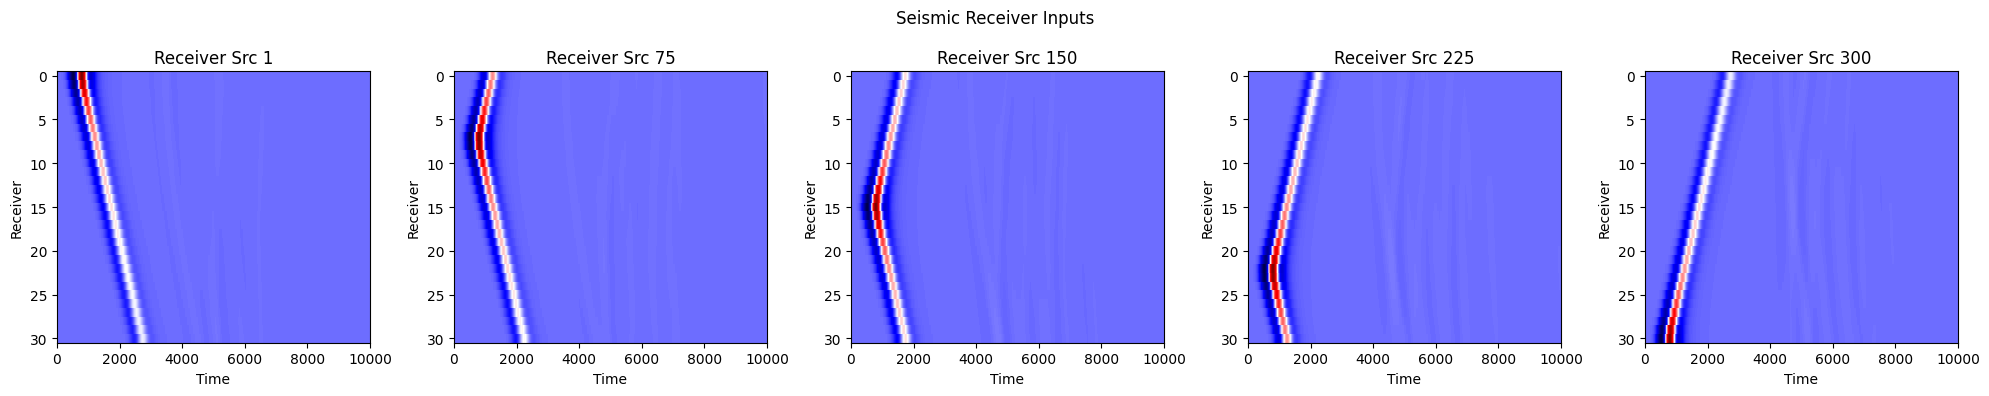

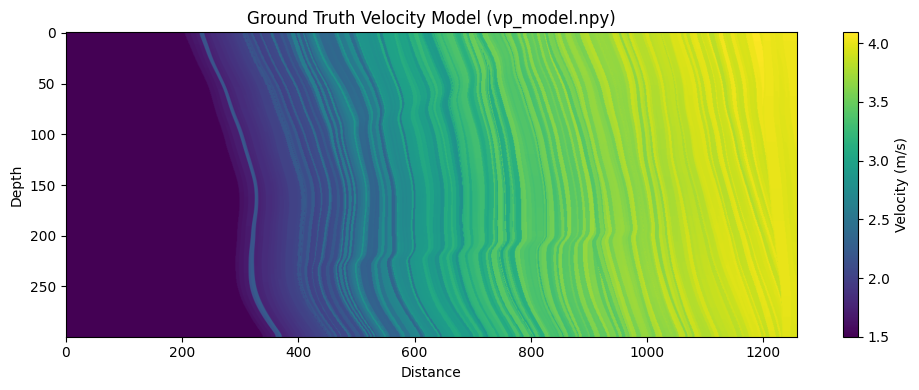

In [9]:
def visualize_sample(sample_path):
    source_positions = [1, 75, 150, 225, 300]
    receiver_data = []

    print(f"🔍 Visualizing sample at: {os.path.basename(sample_path)}")

    # Load seismic receiver inputs with error handling
    for src in source_positions:
        file_path = os.path.join(sample_path, f"receiver_data_src_{src}.npy")
        try:
            data = np.load(file_path)
            receiver_data.append(data)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            receiver_data.append(np.zeros((100, 100)))  # placeholder
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            receiver_data.append(np.zeros((100, 100)))  # placeholder

    # Load velocity model
    try:
        vp_model = np.load(os.path.join(sample_path, "vp_model.npy"))
    except FileNotFoundError:
        print("vp_model.npy not found!")
        return
    except Exception as e:
        print(f"Error loading vp_model.npy: {e}")
        return

    # Plot seismic receiver inputs
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, (data, src) in enumerate(zip(receiver_data, source_positions)):
        axs[i].imshow(data.T, aspect='auto', cmap='seismic', interpolation='none')
        axs[i].set_title(f"Receiver Src {src}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Receiver")
    plt.suptitle("Seismic Receiver Inputs")
    plt.tight_layout()
    plt.show()

    # Plot velocity model
    plt.figure(figsize=(10, 4))
    plt.imshow(vp_model, aspect='auto', cmap='viridis')
    plt.title("Ground Truth Velocity Model (vp_model.npy)")
    plt.xlabel("Distance")
    plt.ylabel("Depth")
    plt.colorbar(label='Velocity (m/s)')
    plt.tight_layout()
    plt.show()


sample_folders = sorted(glob("/content/sample_data/speed-and-structure-train/*"))
visualize_sample(sample_folders[0])



In [10]:
import os
import numpy as np
from glob import glob

# Path to test samples
test_dir = "/content/sample_data/speed-and-structure-test"
test_folders = sorted([f for f in glob(os.path.join(test_dir, "*")) if os.path.isdir(f)])
print(f"🧪 Total test samples: {len(test_folders)}")

# Pick one to inspect
test_sample_path = test_folders[0]
test_sample_id = os.path.basename(test_sample_path)
print(f"\n🔍 Inspecting test sample: {test_sample_id}")

# Load receiver data (no velocity ground truth in test set)
receiver_indices = [1, 75, 150, 225, 300]
for i in receiver_indices:
    file_path = os.path.join(test_sample_path, f"receiver_data_src_{i}.npy")
    try:
        test_data = np.load(file_path)
        print(f"Loaded: receiver_data_src_{i}.npy - shape: {test_data.shape}, dtype: {test_data.dtype}")
    except FileNotFoundError:
        print(f"Missing file: receiver_data_src_{i}.npy")
    except Exception as e:
        print(f"Error loading receiver_data_src_{i}.npy: {e}")


🧪 Total test samples: 150

🔍 Inspecting test sample: 0BFqBxnVIT368FwmdR
✅ Loaded: receiver_data_src_1.npy - shape: (10001, 31), dtype: float32
✅ Loaded: receiver_data_src_75.npy - shape: (10001, 31), dtype: float32
✅ Loaded: receiver_data_src_150.npy - shape: (10001, 31), dtype: float32
✅ Loaded: receiver_data_src_225.npy - shape: (10001, 31), dtype: float32
✅ Loaded: receiver_data_src_300.npy - shape: (10001, 31), dtype: float32


# Data preparation for Training

In [11]:
class SeismicDataset(Dataset):
    def __init__(self, root, is_test=False):
        self.paths = sorted(glob(f"{root}/*"))
        self.is_test = is_test
        self.src_pos = [1, 75, 150, 225, 300]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        folder = self.paths[i]
        x = np.stack([
            np.load(f"{folder}/receiver_data_src_{p}.npy")
            for p in self.src_pos
        ]).astype(np.float32)

        x = torch.from_numpy(x).unsqueeze(0)  # Shape: (1, 5, H, W)
        x = F.interpolate(x, size=(300, 1259), mode='bilinear').squeeze(0)  # → (5, 300, 1259)

        if self.is_test:
            return x, os.path.basename(folder)

        y = torch.from_numpy(np.load(f"{folder}/vp_model.npy").astype(np.float32))
        return x, y

In [12]:
#  Data Setup
train_dir = "/content/sample_data/speed-and-structure-train"
test_dir = "/content/sample_data/speed-and-structure-test"

full_dataset = SeismicDataset(train_dir)
train_idx, val_idx = train_test_split(np.arange(len(full_dataset)), test_size=0.2, random_state=42)

train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=2, shuffle=True)
val_loader = DataLoader(Subset(full_dataset, val_idx), batch_size=1)
test_loader = DataLoader(SeismicDataset(test_dir, is_test=True), batch_size=1)

# Model Defination & Training

In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=1, output_size=(300, 1259)):
        super(UNet, self).__init__()

        def CBR(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = CBR(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)
        self.output_size = output_size

    def center_crop(self, enc_feat, dec_feat):
        _, _, h, w = dec_feat.shape
        return enc_feat[:, :, :h, :w]

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, self.center_crop(e3, d3)], dim=1))
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, self.center_crop(e2, d2)], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, self.center_crop(e1, d1)], dim=1))
        out = self.final(d1)
        out = F.interpolate(out, size=self.output_size, mode='bilinear', align_corners=False)
        return out.squeeze(1)

class MAPELoss(nn.Module):
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, pred, target):
        return torch.mean(torch.abs((target - pred) / (target + self.epsilon)))

In [14]:
def train_model(model, train_loader, val_loader, device, epochs=30, lr=5e-5, save_path="best_model.pt"):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    loss_fn = MAPELoss()

    best_val_mape = float('inf')
    train_losses, val_mapes = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_mape = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_mape += loss_fn(pred, y).item()

        scheduler.step()
        avg_train_loss = train_loss / len(train_loader)
        avg_val_mape = val_mape / len(val_loader)
        train_losses.append(avg_train_loss)
        val_mapes.append(avg_val_mape)

        print(f"✅ Epoch {epoch+1}: Train Loss = {avg_train_loss:.6f}, Val MAPE = {avg_val_mape:.6f}")

        if avg_val_mape < best_val_mape:
            best_val_mape = avg_val_mape
            torch.save(model.state_dict(), save_path)
            print(f"💾 Saved best model with Val MAPE = {best_val_mape:.6f}")

    # Plot loss curves
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_mapes, label="Val MAPE")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / MAPE")
    plt.title("Training Progress")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model

In [15]:
def visualize_batch_predictions(model, dataset, sample_indices, device, cols=3):
    model.eval()
    rows = int(np.ceil(len(sample_indices) / cols))
    fig, axs = plt.subplots(rows, cols * 2, figsize=(cols * 6, rows * 3))

    for i, idx in enumerate(sample_indices):
        x, y_true = dataset[idx]
        x = x.unsqueeze(0).to(device)

        with torch.no_grad():
            y_pred = model(x).squeeze(0).cpu().numpy()

        y_true = y_true.numpy()
        r, c_gt = i // cols, (i % cols) * 2

        axs[r, c_gt].imshow(y_true, aspect='auto', cmap='viridis')
        axs[r, c_gt].set_title(f"GT #{idx}")
        axs[r, c_gt].axis('off')

        axs[r, c_gt + 1].imshow(y_pred, aspect='auto', cmap='viridis')
        axs[r, c_gt + 1].set_title(f"Pred #{idx}")
        axs[r, c_gt + 1].axis('off')

    plt.suptitle("Ground Truth vs Prediction", fontsize=16)
    plt.tight_layout()
    plt.show()

Epoch 1/100: 100%|██████████| 400/400 [00:36<00:00, 10.90it/s]


✅ Epoch 1: Train Loss = 0.536686, Val MAPE = 0.405629
💾 Saved best model with Val MAPE = 0.405629


Epoch 2/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 2: Train Loss = 0.350241, Val MAPE = 0.294970
💾 Saved best model with Val MAPE = 0.294970


Epoch 3/100: 100%|██████████| 400/400 [00:35<00:00, 11.43it/s]


✅ Epoch 3: Train Loss = 0.261710, Val MAPE = 0.231374
💾 Saved best model with Val MAPE = 0.231374


Epoch 4/100: 100%|██████████| 400/400 [00:35<00:00, 11.43it/s]


✅ Epoch 4: Train Loss = 0.205672, Val MAPE = 0.396717


Epoch 5/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 5: Train Loss = 0.182474, Val MAPE = 0.190691
💾 Saved best model with Val MAPE = 0.190691


Epoch 6/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 6: Train Loss = 0.168870, Val MAPE = 0.284086


Epoch 7/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 7: Train Loss = 0.158977, Val MAPE = 0.206309


Epoch 8/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 8: Train Loss = 0.149975, Val MAPE = 0.202357


Epoch 9/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 9: Train Loss = 0.141748, Val MAPE = 0.246588


Epoch 10/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 10: Train Loss = 0.136044, Val MAPE = 0.269264


Epoch 11/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 11: Train Loss = 0.131342, Val MAPE = 0.207461


Epoch 12/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 12: Train Loss = 0.126299, Val MAPE = 0.237498


Epoch 13/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 13: Train Loss = 0.121459, Val MAPE = 0.197955


Epoch 14/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 14: Train Loss = 0.118548, Val MAPE = 0.165164
💾 Saved best model with Val MAPE = 0.165164


Epoch 15/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 15: Train Loss = 0.114868, Val MAPE = 0.256103


Epoch 16/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 16: Train Loss = 0.110512, Val MAPE = 0.194801


Epoch 17/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 17: Train Loss = 0.108289, Val MAPE = 0.227990


Epoch 18/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 18: Train Loss = 0.104930, Val MAPE = 0.180065


Epoch 19/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 19: Train Loss = 0.101835, Val MAPE = 0.142042
💾 Saved best model with Val MAPE = 0.142042


Epoch 20/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 20: Train Loss = 0.099770, Val MAPE = 0.202228


Epoch 21/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 21: Train Loss = 0.097035, Val MAPE = 0.234468


Epoch 22/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 22: Train Loss = 0.095087, Val MAPE = 0.235915


Epoch 23/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 23: Train Loss = 0.092860, Val MAPE = 0.292358


Epoch 24/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 24: Train Loss = 0.091429, Val MAPE = 0.132725
💾 Saved best model with Val MAPE = 0.132725


Epoch 25/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 25: Train Loss = 0.089507, Val MAPE = 0.181556


Epoch 26/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 26: Train Loss = 0.088912, Val MAPE = 0.255740


Epoch 27/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 27: Train Loss = 0.087076, Val MAPE = 0.145514


Epoch 28/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 28: Train Loss = 0.085074, Val MAPE = 0.170831


Epoch 29/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 29: Train Loss = 0.083451, Val MAPE = 0.149275


Epoch 30/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 30: Train Loss = 0.082782, Val MAPE = 0.192390


Epoch 31/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 31: Train Loss = 0.082063, Val MAPE = 0.123523
💾 Saved best model with Val MAPE = 0.123523


Epoch 32/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 32: Train Loss = 0.080540, Val MAPE = 0.311723


Epoch 33/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 33: Train Loss = 0.079620, Val MAPE = 0.174899


Epoch 34/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 34: Train Loss = 0.078764, Val MAPE = 0.124467


Epoch 35/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 35: Train Loss = 0.078259, Val MAPE = 0.164188


Epoch 36/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 36: Train Loss = 0.077257, Val MAPE = 0.174727


Epoch 37/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 37: Train Loss = 0.076375, Val MAPE = 0.126552


Epoch 38/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 38: Train Loss = 0.075763, Val MAPE = 0.208338


Epoch 39/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 39: Train Loss = 0.074313, Val MAPE = 0.126522


Epoch 40/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 40: Train Loss = 0.074020, Val MAPE = 0.159836


Epoch 41/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 41: Train Loss = 0.072955, Val MAPE = 0.103473
💾 Saved best model with Val MAPE = 0.103473


Epoch 42/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 42: Train Loss = 0.072164, Val MAPE = 0.159141


Epoch 43/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 43: Train Loss = 0.071661, Val MAPE = 0.112246


Epoch 44/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 44: Train Loss = 0.071305, Val MAPE = 0.148772


Epoch 45/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 45: Train Loss = 0.071124, Val MAPE = 0.131169


Epoch 46/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 46: Train Loss = 0.069961, Val MAPE = 0.242945


Epoch 47/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 47: Train Loss = 0.069512, Val MAPE = 0.206214


Epoch 48/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 48: Train Loss = 0.069236, Val MAPE = 0.193585


Epoch 49/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 49: Train Loss = 0.068317, Val MAPE = 0.179255


Epoch 50/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 50: Train Loss = 0.067533, Val MAPE = 0.218406


Epoch 51/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 51: Train Loss = 0.067041, Val MAPE = 0.188405


Epoch 52/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 52: Train Loss = 0.066389, Val MAPE = 0.095389
💾 Saved best model with Val MAPE = 0.095389


Epoch 53/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 53: Train Loss = 0.066279, Val MAPE = 0.165837


Epoch 54/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 54: Train Loss = 0.065955, Val MAPE = 0.118333


Epoch 55/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 55: Train Loss = 0.065162, Val MAPE = 0.230934


Epoch 56/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 56: Train Loss = 0.064877, Val MAPE = 0.094318
💾 Saved best model with Val MAPE = 0.094318


Epoch 57/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 57: Train Loss = 0.064509, Val MAPE = 0.121545


Epoch 58/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 58: Train Loss = 0.063768, Val MAPE = 0.090560
💾 Saved best model with Val MAPE = 0.090560


Epoch 59/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 59: Train Loss = 0.063450, Val MAPE = 0.092528


Epoch 60/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 60: Train Loss = 0.063107, Val MAPE = 0.154141


Epoch 61/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 61: Train Loss = 0.062567, Val MAPE = 0.178434


Epoch 62/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 62: Train Loss = 0.062741, Val MAPE = 0.087623
💾 Saved best model with Val MAPE = 0.087623


Epoch 63/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 63: Train Loss = 0.062044, Val MAPE = 0.102149


Epoch 64/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 64: Train Loss = 0.061659, Val MAPE = 0.150171


Epoch 65/100: 100%|██████████| 400/400 [00:35<00:00, 11.43it/s]


✅ Epoch 65: Train Loss = 0.061321, Val MAPE = 0.143212


Epoch 66/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 66: Train Loss = 0.060848, Val MAPE = 0.107530


Epoch 67/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 67: Train Loss = 0.060579, Val MAPE = 0.094926


Epoch 68/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 68: Train Loss = 0.059889, Val MAPE = 0.090488


Epoch 69/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 69: Train Loss = 0.060067, Val MAPE = 0.112277


Epoch 70/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 70: Train Loss = 0.059671, Val MAPE = 0.127408


Epoch 71/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 71: Train Loss = 0.059205, Val MAPE = 0.156756


Epoch 72/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 72: Train Loss = 0.058872, Val MAPE = 0.117924


Epoch 73/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 73: Train Loss = 0.058929, Val MAPE = 0.093438


Epoch 74/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 74: Train Loss = 0.058695, Val MAPE = 0.082193
💾 Saved best model with Val MAPE = 0.082193


Epoch 75/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 75: Train Loss = 0.058251, Val MAPE = 0.115830


Epoch 76/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 76: Train Loss = 0.058131, Val MAPE = 0.089819


Epoch 77/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 77: Train Loss = 0.057845, Val MAPE = 0.073381
💾 Saved best model with Val MAPE = 0.073381


Epoch 78/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 78: Train Loss = 0.057733, Val MAPE = 0.072668
💾 Saved best model with Val MAPE = 0.072668


Epoch 79/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 79: Train Loss = 0.057389, Val MAPE = 0.075851


Epoch 80/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 80: Train Loss = 0.057187, Val MAPE = 0.072082
💾 Saved best model with Val MAPE = 0.072082


Epoch 81/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 81: Train Loss = 0.057051, Val MAPE = 0.083490


Epoch 82/100: 100%|██████████| 400/400 [00:35<00:00, 11.43it/s]


✅ Epoch 82: Train Loss = 0.056912, Val MAPE = 0.073751


Epoch 83/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 83: Train Loss = 0.056725, Val MAPE = 0.070382
💾 Saved best model with Val MAPE = 0.070382


Epoch 84/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 84: Train Loss = 0.056467, Val MAPE = 0.072279


Epoch 85/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 85: Train Loss = 0.056344, Val MAPE = 0.074853


Epoch 86/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 86: Train Loss = 0.056273, Val MAPE = 0.077721


Epoch 87/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 87: Train Loss = 0.056277, Val MAPE = 0.072021


Epoch 88/100: 100%|██████████| 400/400 [00:35<00:00, 11.43it/s]


✅ Epoch 88: Train Loss = 0.055892, Val MAPE = 0.073528


Epoch 89/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 89: Train Loss = 0.056175, Val MAPE = 0.072197


Epoch 90/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 90: Train Loss = 0.055845, Val MAPE = 0.070014
💾 Saved best model with Val MAPE = 0.070014


Epoch 91/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 91: Train Loss = 0.055805, Val MAPE = 0.070738


Epoch 92/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 92: Train Loss = 0.055675, Val MAPE = 0.071757


Epoch 93/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 93: Train Loss = 0.055738, Val MAPE = 0.070321


Epoch 94/100: 100%|██████████| 400/400 [00:35<00:00, 11.43it/s]


✅ Epoch 94: Train Loss = 0.055649, Val MAPE = 0.070091


Epoch 95/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 95: Train Loss = 0.055382, Val MAPE = 0.069537
💾 Saved best model with Val MAPE = 0.069537


Epoch 96/100: 100%|██████████| 400/400 [00:34<00:00, 11.44it/s]


✅ Epoch 96: Train Loss = 0.055364, Val MAPE = 0.069565


Epoch 97/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 97: Train Loss = 0.055554, Val MAPE = 0.069574


Epoch 98/100: 100%|██████████| 400/400 [00:35<00:00, 11.43it/s]


✅ Epoch 98: Train Loss = 0.055159, Val MAPE = 0.069374
💾 Saved best model with Val MAPE = 0.069374


Epoch 99/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 99: Train Loss = 0.055376, Val MAPE = 0.069915


Epoch 100/100: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Epoch 100: Train Loss = 0.055365, Val MAPE = 0.069536


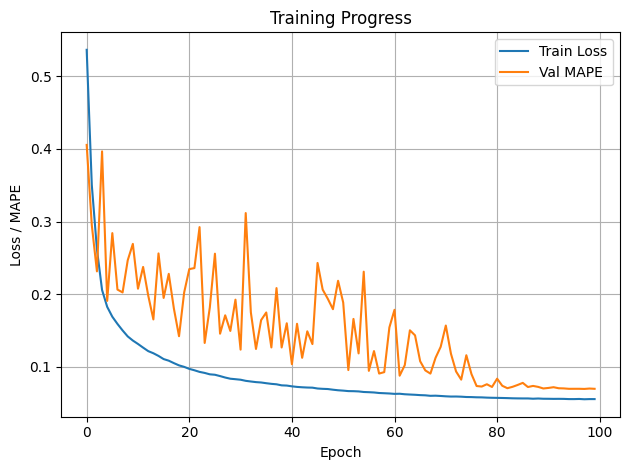

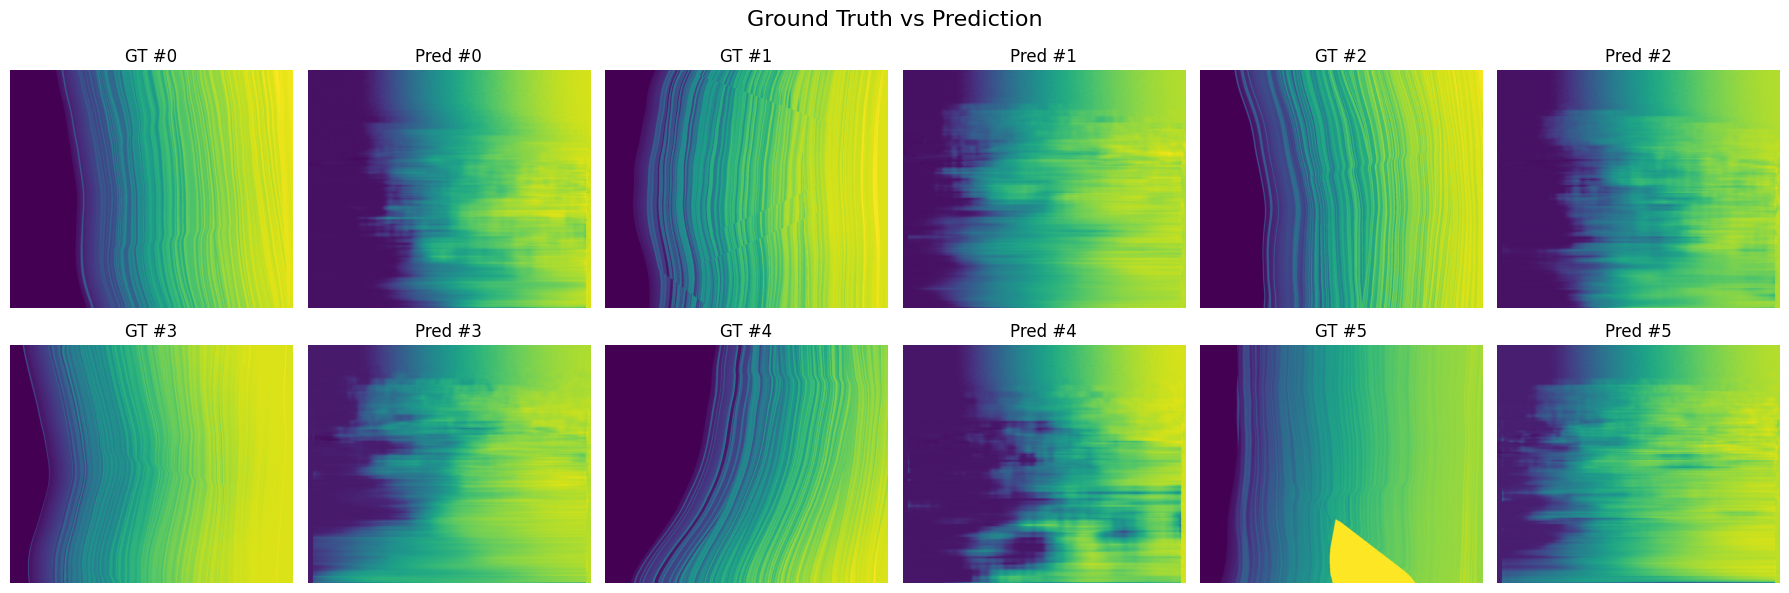

In [16]:
# Config
train_dir = "/content/sample_data/speed-and-structure-train"
test_dir = "/content/sample_data/speed-and-structure-test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datasets and Loaders
full_dataset = SeismicDataset(train_dir)
train_idx, val_idx = train_test_split(np.arange(len(full_dataset)), test_size=0.2, random_state=42)

train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(Subset(full_dataset, val_idx), batch_size=1, num_workers=2, pin_memory=True)

# Model
model = UNet().to(device)

# Train
model = train_model(model, train_loader, val_loader, device=device, epochs=100, lr=5e-5)

# Visualize
sample_indices = [0, 1, 2, 3, 4, 5]
visualize_batch_predictions(model, full_dataset, sample_indices, device)

# Evaluation

Evaluating MAPE: 100%|██████████| 400/400 [00:11<00:00, 34.47it/s]


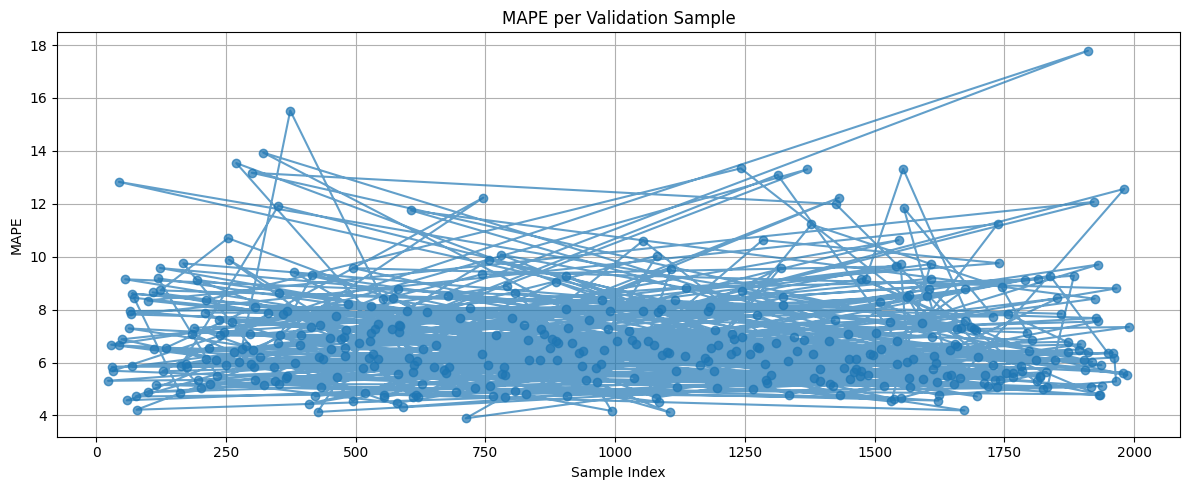

📊 Mean Validation MAPE: 6.953631
   sample_index      mape
0          1860  7.843039
1           353  8.622201
2          1333  6.048817
3           905  9.272138
4          1289  5.941482


In [18]:
import pandas as pd

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def evaluate_per_sample(model, dataset, indices, device):
    model.eval()
    mape_records = []

    with torch.no_grad():
        for idx in tqdm(indices, desc="Evaluating MAPE"):
            x, y_true = dataset[idx]
            x = x.unsqueeze(0).to(device)
            y_true_np = y_true.numpy()

            y_pred = model(x).squeeze(0).cpu().numpy()
            mape = calculate_mape(y_true_np, y_pred)

            mape_records.append({
                "sample_index": idx,
                "mape": mape
            })

    return pd.DataFrame(mape_records)

# Evaluate on validation set
val_df = evaluate_per_sample(model, full_dataset, val_idx, device)

# 📈 Plot MAPE per sample
plt.figure(figsize=(12, 5))
plt.plot(val_df["sample_index"], val_df["mape"], marker='o', linestyle='-', alpha=0.7)
plt.title("MAPE per Validation Sample")
plt.xlabel("Sample Index")
plt.ylabel("MAPE")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print average MAPE
mean_val_mape = val_df["mape"].mean()
print(f"📊 Mean Validation MAPE: {mean_val_mape:.6f}")

# Save to CSV
val_df.to_csv("/content/validation_mape_per_sample.csv", index=False)

# Reload and inspect
import pandas as pd
csv_path = "/content/validation_mape_per_sample.csv"
df = pd.read_csv(csv_path)
print(df.head())

# Submission

In [19]:
## 📦 Section 7: Inference & Submission
submission_path = "/content/speed_structure_submission.npz"
if os.path.exists(submission_path):
    os.remove(submission_path)

model.eval()
with torch.no_grad():
    for x, sample_id in tqdm(test_loader):
        x = x.to(device)
        pred = model(x).squeeze(0).cpu().numpy().astype(np.float64)
        create_submission(sample_id[0], pred, submission_path)

## 🔗 Section 8: Colab Download Link
FileLink(submission_path)

100%|██████████| 150/150 [02:28<00:00,  1.01it/s]


/content/speed_structure_submission.npz

In [20]:
## ✅ Section 7: Submission Sanity Check
def validate_submission_file(sub_path, expected=150):
    if not os.path.exists(sub_path): return print("❌ File missing")
    data = np.load(sub_path); keys = list(data.keys())
    print(f"✅ {len(keys)} predictions found.")
    bad = [(k, v.shape, v.dtype) for k, v in data.items() if v.shape != (300,1259) or v.dtype != np.float64]
    if bad:
        print(f"⚠️ {len(bad)} bad entries:", bad[:3])
    else:
        print("🏁 Submission looks good!")

validate_submission_file(submission_path)

✅ 150 predictions found.
🏁 Submission looks good!
